In [18]:
import jax.numpy as np
import jax.scipy as sp 
from jax import grad, jit, vmap, random
from jax.ops import index, index_add, index_update
from jax.experimental.optimizers import adagrad, adam

import time
import numpy as onp
# -- plotting --- 
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
Ndata = 5
n_grid = 15
pix_1d = np.linspace(0., 1., n_grid) # pixel gridding

fdensity_true = float(Ndata)/float(n_grid**2); #number density of obj in 1d

sig_psf = 0.1 # psf width
sig_noise = 0.1 # noise level

/Users/ChangHoon/opt/anaconda3/envs/sparse/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
#create our psf
mid = int(n_grid/2);
x,y = np.meshgrid(pix_1d, pix_1d)
psf = np.exp(-((y-pix_1d[mid])**2 + (x - pix_1d[mid])**2)/2/sig_psf**2) #keep in mind difference between x and y position and indices! Here, you are given indices, but meshgrid is in x-y coords

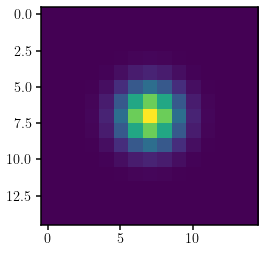

In [4]:
#display psf
plt.imshow(psf)

In [5]:
#fourier transform of psf
psf_k = np.fft.fft2(psf)

In [6]:
def real_to_complex(z):      # real vector of length 2n -> complex of length n
    return z[:len(z)//2] + 1j * z[len(z)//2:]

def complex_to_real(z):      # complex vector of length n -> real of length 2n
    return np.real(np.concatenate((np.real(z), np.imag(z))))

def fm(ws_k): 
    ws_k = real_to_complex(ws_k) #2*reals -> complex
    ws_k = ws_k.reshape((n_grid,n_grid)) #reshape to 2d
    return np.real(np.fft.ifft2(ws_k*psf_k)) #convolution of ws with psf

In [7]:
#create the mock data we will work on
#create coordinate grid
theta_grid = np.linspace(0., 1., n_grid) # gridding of theta (same as pixels)

#create true values - assign to grid
key = random.PRNGKey(0)
key0, key1, key2 = random.split(key, num=3)
x_true = random.uniform(key0, (Ndata,)) #np.abs(np.random.rand(Ndata)) # location of sources
y_true = random.uniform(key1, (Ndata,))
w_true = random.uniform(key2, (Ndata,))*2 # with intensity betwen 1-2

#true grid needs to be set up with noise
w_true_grid = np.zeros((n_grid,n_grid))
for x, y, w in zip(x_true, y_true, w_true): 
    w_true_grid = index_update(w_true_grid, index[np.argmin(np.abs(theta_grid - x)), np.argmin(np.abs(theta_grid - y))], w)
    
#data = np.real(np.fft.ifft2(np.fft.fft2(w_true_grid)*psf_k)) + sig_noise* random.normal(key, (n_grid,n_grid));
data = fm(complex_to_real(np.fft.fft2(w_true_grid))) + sig_noise* random.normal(key, (n_grid,n_grid))

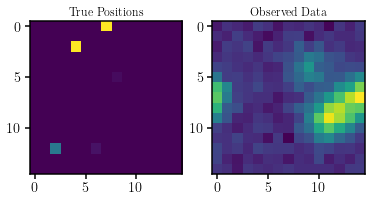

In [8]:
#display the true coordinates and observed data
fig, ax = plt.subplots(1,2)
ax[0].imshow(w_true_grid)
ax[0].set_title('True Positions')
ax[1].imshow(data)
ax[1].set_title('Observed Data')
plt.show()

In [9]:
def loss_prior(ws_k, details=False): 
    ''' log prior
    
    p(w) = (1 - f - f^2) delta_d(w) + f p1(x) + f^2 p2(x)

    we can approximate 
    - delta_d(w) = N(log(w); log(w0), sigma)/w
    - delta_d(w) = N(w; 0, sigma) where sigma << 1
    '''
    ws_k = real_to_complex(ws_k) #2*reals -> complex
    ws_k = ws_k.reshape((n_grid,n_grid)) #reshape to 2d
    
    p1 = 0
    p2 = 0

    ws = np.real(np.fft.ifft2(ws_k))
    
    approx_delta = np.exp(-0.5 * ((ws/0.1)**2))
    #norm_mean = -5. #mean for lognormal
    #norm_sig = 0.1
    #approx_delta = np.exp(-0.5*(np.log(ws) - norm_mean)**2 /norm_sig**2)/np.sqrt(2*np.pi)/norm_sig/ws
    if details: print('        delta_d:', approx_delta)
    prior = np.clip(1e-37, approx_delta * (1 - fdensity_true - fdensity_true**2))# + p1*fdensity_true + p2*fdensity_true**2; #full prior
    return np.sum(np.log(prior))

def loss_like(ws_k, details=False): 
    conv = fm(ws_k)
    if details: 
        print('        d - m:', conv - data)
    return 0.5 * np.sum((conv - data)**2) /sig_noise**2

def loss_fn(ws_k, details=False):
    ''' posterior
    '''
    loglike = loss_like(ws_k, details=details) 
    logprior = loss_prior(ws_k, details=details)
    if details: 
        print('    log likelihood: %f' % loglike)
        print('    log prior: %f' % logprior)
    return loglike - logprior

In [10]:
#create initial parameters
tt0 = np.zeros((n_grid,n_grid)) + 3; #begin with high uniform mass in each pixel
tt0_k = np.fft.fft2(tt0); #take fft
t_ini = complex_to_real(tt0_k.flatten()) #flatten to 1d for scipy and embed in 2R

In [23]:
t0 = time.time() 
print('inital loss: %.5e' % (loss_fn(t_ini, details=True)))
init_fun, update_fun, get_params = adagrad(1.)

@jit # ~3x faster with jit
def opt_step(opt_state): 
    tt = get_params(opt_state)
    g = grad(loss_fn)(tt)
    opt_state = update_fun(i, g, opt_state)
    return tt, opt_state

opt_state = init_fun(t_ini)
for i in range(10000):
    tt, opt_state = opt_step(opt_state)
    if np.isnan(loss_fn(tt)): 
        _w_k = real_to_complex(tt)
        _w_k = _w_k.reshape((n_grid,n_grid)) #reshape to 2d
        print('--- w(x) ---')
        print(_w)
        print(loss_fn(tt, details=True))
        break 
        
    print('%i loss:%f' % (i, loss_fn(tt)))
t_f = get_params(opt_state)

print('final loss: %.5e' % (loss_fn(t_f, details=True)))
print('took %f' % (time.time() - t0))

        d - m: [[37.07876  36.900276 36.96075  37.05557  36.813774 36.904335 37.107037
  36.94034  36.960697 36.882587 36.958607 37.204826 36.87449  37.020077
  36.840153]
 [36.933056 37.023552 36.796326 36.936985 37.042877 37.16291  37.010796
  36.810627 36.80256  37.134636 36.934933 36.8529   36.9591   36.95656
  36.852623]
 [37.056816 36.821793 36.869736 36.76986  37.111565 36.826805 36.94972
  36.850502 36.53764  36.79783  36.606865 36.897636 36.8365   36.96506
  36.94359 ]
 [36.95239  36.858925 36.905594 36.882866 36.95961  36.862473 36.766254
  36.698097 36.564587 36.267616 36.372265 36.634163 36.68243  36.852264
  36.897778]
 [36.766235 36.80948  36.894108 36.94499  36.873558 37.016163 36.98215
  36.649914 36.340187 36.013542 36.527603 36.578926 36.722816 36.696583
  36.71829 ]
 [36.321224 36.81798  36.7962   36.903034 36.81354  36.959564 36.932884
  36.61958  36.43801  36.208122 36.285828 36.592106 36.581524 36.37378
  36.13145 ]
 [35.6105   36.15813  36.81824  36.850636 36.736

213 loss:13960467.000000
214 loss:13957486.000000
215 loss:13954508.000000
216 loss:13951540.000000
217 loss:13948576.000000
218 loss:13945622.000000
219 loss:13942676.000000
220 loss:13939739.000000
221 loss:13936808.000000
222 loss:13933883.000000
223 loss:13930967.000000
224 loss:13928058.000000
225 loss:13925153.000000
226 loss:13922259.000000
227 loss:13919373.000000
228 loss:13916489.000000
229 loss:13913614.000000
230 loss:13910745.000000
231 loss:13907886.000000
232 loss:13905030.000000
233 loss:13902183.000000
234 loss:13899344.000000
235 loss:13896511.000000
236 loss:13893684.000000
237 loss:13890864.000000
238 loss:13888051.000000
239 loss:13885242.000000
240 loss:13882442.000000
241 loss:13879648.000000
242 loss:13876861.000000
243 loss:13874080.000000
244 loss:13871308.000000
245 loss:13868534.000000
246 loss:13865770.000000
247 loss:13863015.000000
248 loss:13860265.000000
249 loss:13857520.000000
250 loss:13854784.000000
251 loss:13852048.000000
252 loss:13849325.000000


544 loss:13218746.000000
545 loss:13216966.000000
546 loss:13215188.000000
547 loss:13213416.000000
548 loss:13211643.000000
549 loss:13209873.000000
550 loss:13208102.000000
551 loss:13206335.000000
552 loss:13204571.000000
553 loss:13202805.000000
554 loss:13201044.000000
555 loss:13199285.000000
556 loss:13197524.000000
557 loss:13195769.000000
558 loss:13194015.000000
559 loss:13192262.000000
560 loss:13190509.000000
561 loss:13188762.000000
562 loss:13187013.000000
563 loss:13185266.000000
564 loss:13183524.000000
565 loss:13181779.000000
566 loss:13180038.000000
567 loss:13178301.000000
568 loss:13176562.000000
569 loss:13174827.000000
570 loss:13173093.000000
571 loss:13171362.000000
572 loss:13169632.000000
573 loss:13167901.000000
574 loss:13166176.000000
575 loss:13164449.000000
576 loss:13162723.000000
577 loss:13161005.000000
578 loss:13159280.000000
579 loss:13157563.000000
580 loss:13155843.000000
581 loss:13154127.000000
582 loss:13152413.000000
583 loss:13150702.000000


872 loss:12711263.000000
873 loss:12709900.000000
874 loss:12708537.000000
875 loss:12707172.000000
876 loss:12705813.000000
877 loss:12704452.000000
878 loss:12703092.000000
879 loss:12701734.000000
880 loss:12700375.000000
881 loss:12699018.000000
882 loss:12697663.000000
883 loss:12696307.000000
884 loss:12694954.000000
885 loss:12693602.000000
886 loss:12692249.000000
887 loss:12690896.000000
888 loss:12689547.000000
889 loss:12688196.000000
890 loss:12686849.000000
891 loss:12685502.000000
892 loss:12684154.000000
893 loss:12682808.000000
894 loss:12681461.000000
895 loss:12680115.000000
896 loss:12678772.000000
897 loss:12677428.000000
898 loss:12676085.000000
899 loss:12674745.000000
900 loss:12673403.000000
901 loss:12672067.000000
902 loss:12670728.000000
903 loss:12669388.000000
904 loss:12668053.000000
905 loss:12666717.000000
906 loss:12665382.000000
907 loss:12664046.000000
908 loss:12662712.000000
909 loss:12661381.000000
910 loss:12660046.000000
911 loss:12658717.000000


1193 loss:12312092.000000
1194 loss:12310939.000000
1195 loss:12309790.000000
1196 loss:12308640.000000
1197 loss:12307486.000000
1198 loss:12306333.000000
1199 loss:12305180.000000
1200 loss:12304028.000000
1201 loss:12302875.000000
1202 loss:12301724.000000
1203 loss:12300577.000000
1204 loss:12299428.000000
1205 loss:12298283.000000
1206 loss:12297139.000000
1207 loss:12295996.000000
1208 loss:12294854.000000
1209 loss:12293714.000000
1210 loss:12292575.000000
1211 loss:12291439.000000
1212 loss:12290306.000000
1213 loss:12289171.000000
1214 loss:12288039.000000
1215 loss:12286906.000000
1216 loss:12285776.000000
1217 loss:12284648.000000
1218 loss:12283520.000000
1219 loss:12282388.000000
1220 loss:12281257.000000
1221 loss:12280131.000000
1222 loss:12278998.000000
1223 loss:12277869.000000
1224 loss:12276740.000000
1225 loss:12275607.000000
1226 loss:12274481.000000
1227 loss:12273353.000000
1228 loss:12272227.000000
1229 loss:12271100.000000
1230 loss:12269971.000000
1231 loss:12

1516 loss:11968923.000000
1517 loss:11967928.000000
1518 loss:11966938.000000
1519 loss:11965948.000000
1520 loss:11964958.000000
1521 loss:11963971.000000
1522 loss:11962980.000000
1523 loss:11961990.000000
1524 loss:11961001.000000
1525 loss:11960013.000000
1526 loss:11959027.000000
1527 loss:11958041.000000
1528 loss:11957053.000000
1529 loss:11956067.000000
1530 loss:11955081.000000
1531 loss:11954094.000000
1532 loss:11953109.000000
1533 loss:11952127.000000
1534 loss:11951141.000000
1535 loss:11950157.000000
1536 loss:11949173.000000
1537 loss:11948188.000000
1538 loss:11947204.000000
1539 loss:11946222.000000
1540 loss:11945238.000000
1541 loss:11944258.000000
1542 loss:11943277.000000
1543 loss:11942296.000000
1544 loss:11941314.000000
1545 loss:11940334.000000
1546 loss:11939351.000000
1547 loss:11938368.000000
1548 loss:11937386.000000
1549 loss:11936404.000000
1550 loss:11935421.000000
1551 loss:11934437.000000
1552 loss:11933451.000000
1553 loss:11932469.000000
1554 loss:11

1847 loss:11659669.000000
1848 loss:11658786.000000
1849 loss:11657905.000000
1850 loss:11657023.000000
1851 loss:11656143.000000
1852 loss:11655264.000000
1853 loss:11654385.000000
1854 loss:11653503.000000
1855 loss:11652623.000000
1856 loss:11651743.000000
1857 loss:11650863.000000
1858 loss:11649985.000000
1859 loss:11649108.000000
1860 loss:11648231.000000
1861 loss:11647351.000000
1862 loss:11646477.000000
1863 loss:11645599.000000
1864 loss:11644721.000000
1865 loss:11643843.000000
1866 loss:11642966.000000
1867 loss:11642091.000000
1868 loss:11641213.000000
1869 loss:11640339.000000
1870 loss:11639464.000000
1871 loss:11638589.000000
1872 loss:11637715.000000
1873 loss:11636841.000000
1874 loss:11635964.000000
1875 loss:11635091.000000
1876 loss:11634217.000000
1877 loss:11633342.000000
1878 loss:11632467.000000
1879 loss:11631597.000000
1880 loss:11630726.000000
1881 loss:11629853.000000
1882 loss:11628980.000000
1883 loss:11628110.000000
1884 loss:11627238.000000
1885 loss:11

2166 loss:11391754.000000
2167 loss:11390955.000000
2168 loss:11390156.000000
2169 loss:11389353.000000
2170 loss:11388553.000000
2171 loss:11387753.000000
2172 loss:11386953.000000
2173 loss:11386153.000000
2174 loss:11385353.000000
2175 loss:11384550.000000
2176 loss:11383753.000000
2177 loss:11382957.000000
2178 loss:11382157.000000
2179 loss:11381360.000000
2180 loss:11380560.000000
2181 loss:11379763.000000
2182 loss:11378967.000000
2183 loss:11378168.000000
2184 loss:11377370.000000
2185 loss:11376573.000000
2186 loss:11375774.000000
2187 loss:11374978.000000
2188 loss:11374183.000000
2189 loss:11373386.000000
2190 loss:11372593.000000
2191 loss:11371796.000000
2192 loss:11371002.000000
2193 loss:11370207.000000
2194 loss:11369410.000000
2195 loss:11368615.000000
2196 loss:11367818.000000
2197 loss:11367021.000000
2198 loss:11366221.000000
2199 loss:11365421.000000
2200 loss:11364625.000000
2201 loss:11363825.000000
2202 loss:11363028.000000
2203 loss:11362230.000000
2204 loss:11

2487 loss:11144997.000000
2488 loss:11144257.000000
2489 loss:11143518.000000
2490 loss:11142777.000000
2491 loss:11142037.000000
2492 loss:11141296.000000
2493 loss:11140557.000000
2494 loss:11139818.000000
2495 loss:11139077.000000
2496 loss:11138341.000000
2497 loss:11137602.000000
2498 loss:11136864.000000
2499 loss:11136125.000000
2500 loss:11135385.000000
2501 loss:11134650.000000
2502 loss:11133913.000000
2503 loss:11133178.000000
2504 loss:11132444.000000
2505 loss:11131710.000000
2506 loss:11130977.000000
2507 loss:11130243.000000
2508 loss:11129510.000000
2509 loss:11128774.000000
2510 loss:11128043.000000
2511 loss:11127310.000000
2512 loss:11126575.000000
2513 loss:11125840.000000
2514 loss:11125102.000000
2515 loss:11124368.000000
2516 loss:11123631.000000
2517 loss:11122895.000000
2518 loss:11122159.000000
2519 loss:11121426.000000
2520 loss:11120690.000000
2521 loss:11119955.000000
2522 loss:11119221.000000
2523 loss:11118489.000000
2524 loss:11117756.000000
2525 loss:11

2817 loss:10910947.000000
2818 loss:10910267.000000
2819 loss:10909586.000000
2820 loss:10908906.000000
2821 loss:10908226.000000
2822 loss:10907544.000000
2823 loss:10906865.000000
2824 loss:10906183.000000
2825 loss:10905503.000000
2826 loss:10904823.000000
2827 loss:10904141.000000
2828 loss:10903462.000000
2829 loss:10902780.000000
2830 loss:10902101.000000
2831 loss:10901420.000000
2832 loss:10900736.000000
2833 loss:10900059.000000
2834 loss:10899379.000000
2835 loss:10898697.000000
2836 loss:10898021.000000
2837 loss:10897343.000000
2838 loss:10896664.000000
2839 loss:10895986.000000
2840 loss:10895309.000000
2841 loss:10894632.000000
2842 loss:10893957.000000
2843 loss:10893276.000000
2844 loss:10892598.000000
2845 loss:10891919.000000
2846 loss:10891242.000000
2847 loss:10890564.000000
2848 loss:10889886.000000
2849 loss:10889210.000000
2850 loss:10888532.000000
2851 loss:10887854.000000
2852 loss:10887176.000000
2853 loss:10886500.000000
2854 loss:10885823.000000
2855 loss:10

3139 loss:10698580.000000
3140 loss:10697938.000000
3141 loss:10697298.000000
3142 loss:10696659.000000
3143 loss:10696019.000000
3144 loss:10695381.000000
3145 loss:10694742.000000
3146 loss:10694105.000000
3147 loss:10693463.000000
3148 loss:10692826.000000
3149 loss:10692189.000000
3150 loss:10691549.000000
3151 loss:10690912.000000
3152 loss:10690274.000000
3153 loss:10689639.000000
3154 loss:10689003.000000
3155 loss:10688369.000000
3156 loss:10687735.000000
3157 loss:10687099.000000
3158 loss:10686463.000000
3159 loss:10685830.000000
3160 loss:10685196.000000
3161 loss:10684564.000000
3162 loss:10683927.000000
3163 loss:10683293.000000
3164 loss:10682659.000000
3165 loss:10682025.000000
3166 loss:10681390.000000
3167 loss:10680756.000000
3168 loss:10680121.000000
3169 loss:10679486.000000
3170 loss:10678853.000000
3171 loss:10678220.000000
3172 loss:10677583.000000
3173 loss:10676949.000000
3174 loss:10676319.000000
3175 loss:10675688.000000
3176 loss:10675054.000000
3177 loss:10

3464 loss:10497556.000000
3465 loss:10496959.000000
3466 loss:10496362.000000
3467 loss:10495762.000000
3468 loss:10495162.000000
3469 loss:10494563.000000
3470 loss:10493965.000000
3471 loss:10493366.000000
3472 loss:10492768.000000
3473 loss:10492168.000000
3474 loss:10491572.000000
3475 loss:10490973.000000
3476 loss:10490377.000000
3477 loss:10489782.000000
3478 loss:10489185.000000
3479 loss:10488587.000000
3480 loss:10487992.000000
3481 loss:10487396.000000
3482 loss:10486800.000000
3483 loss:10486205.000000
3484 loss:10485607.000000
3485 loss:10485011.000000
3486 loss:10484414.000000
3487 loss:10483819.000000
3488 loss:10483223.000000
3489 loss:10482626.000000
3490 loss:10482030.000000
3491 loss:10481437.000000
3492 loss:10480837.000000
3493 loss:10480242.000000
3494 loss:10479645.000000
3495 loss:10479050.000000
3496 loss:10478452.000000
3497 loss:10477857.000000
3498 loss:10477261.000000
3499 loss:10476666.000000
3500 loss:10476069.000000
3501 loss:10475479.000000
3502 loss:10

3786 loss:10310262.000000
3787 loss:10309695.000000
3788 loss:10309129.000000
3789 loss:10308564.000000
3790 loss:10307997.000000
3791 loss:10307430.000000
3792 loss:10306868.000000
3793 loss:10306304.000000
3794 loss:10305739.000000
3795 loss:10305176.000000
3796 loss:10304612.000000
3797 loss:10304049.000000
3798 loss:10303485.000000
3799 loss:10302923.000000
3800 loss:10302356.000000
3801 loss:10301797.000000
3802 loss:10301231.000000
3803 loss:10300667.000000
3804 loss:10300103.000000
3805 loss:10299541.000000
3806 loss:10298977.000000
3807 loss:10298414.000000
3808 loss:10297849.000000
3809 loss:10297285.000000
3810 loss:10296723.000000
3811 loss:10296159.000000
3812 loss:10295597.000000
3813 loss:10295030.000000
3814 loss:10294469.000000
3815 loss:10293904.000000
3816 loss:10293341.000000
3817 loss:10292778.000000
3818 loss:10292218.000000
3819 loss:10291650.000000
3820 loss:10291089.000000
3821 loss:10290528.000000
3822 loss:10289966.000000
3823 loss:10289404.000000
3824 loss:10

4118 loss:10127611.000000
4119 loss:10127073.000000
4120 loss:10126537.000000
4121 loss:10126000.000000
4122 loss:10125464.000000
4123 loss:10124930.000000
4124 loss:10124400.000000
4125 loss:10123863.000000
4126 loss:10123329.000000
4127 loss:10122796.000000
4128 loss:10122261.000000
4129 loss:10121726.000000
4130 loss:10121193.000000
4131 loss:10120660.000000
4132 loss:10120124.000000
4133 loss:10119592.000000
4134 loss:10119057.000000
4135 loss:10118522.000000
4136 loss:10117991.000000
4137 loss:10117457.000000
4138 loss:10116922.000000
4139 loss:10116389.000000
4140 loss:10115854.000000
4141 loss:10115322.000000
4142 loss:10114789.000000
4143 loss:10114254.000000
4144 loss:10113720.000000
4145 loss:10113186.000000
4146 loss:10112652.000000
4147 loss:10112119.000000
4148 loss:10111586.000000
4149 loss:10111053.000000
4150 loss:10110517.000000
4151 loss:10109985.000000
4152 loss:10109450.000000
4153 loss:10108918.000000
4154 loss:10108384.000000
4155 loss:10107853.000000
4156 loss:10

4439 loss:9959925.000000
4440 loss:9959416.000000
4441 loss:9958905.000000
4442 loss:9958397.000000
4443 loss:9957887.000000
4444 loss:9957379.000000
4445 loss:9956868.000000
4446 loss:9956358.000000
4447 loss:9955849.000000
4448 loss:9955340.000000
4449 loss:9954830.000000
4450 loss:9954321.000000
4451 loss:9953811.000000
4452 loss:9953302.000000
4453 loss:9952792.000000
4454 loss:9952285.000000
4455 loss:9951774.000000
4456 loss:9951265.000000
4457 loss:9950756.000000
4458 loss:9950247.000000
4459 loss:9949737.000000
4460 loss:9949229.000000
4461 loss:9948718.000000
4462 loss:9948210.000000
4463 loss:9947704.000000
4464 loss:9947194.000000
4465 loss:9946689.000000
4466 loss:9946182.000000
4467 loss:9945673.000000
4468 loss:9945168.000000
4469 loss:9944661.000000
4470 loss:9944155.000000
4471 loss:9943647.000000
4472 loss:9943140.000000
4473 loss:9942634.000000
4474 loss:9942126.000000
4475 loss:9941620.000000
4476 loss:9941114.000000
4477 loss:9940606.000000
4478 loss:9940100.000000


4774 loss:9793051.000000
4775 loss:9792566.000000
4776 loss:9792080.000000
4777 loss:9791596.000000
4778 loss:9791110.000000
4779 loss:9790624.000000
4780 loss:9790139.000000
4781 loss:9789654.000000
4782 loss:9789169.000000
4783 loss:9788684.000000
4784 loss:9788198.000000
4785 loss:9787714.000000
4786 loss:9787228.000000
4787 loss:9786743.000000
4788 loss:9786259.000000
4789 loss:9785772.000000
4790 loss:9785288.000000
4791 loss:9784802.000000
4792 loss:9784317.000000
4793 loss:9783834.000000
4794 loss:9783349.000000
4795 loss:9782862.000000
4796 loss:9782377.000000
4797 loss:9781892.000000
4798 loss:9781409.000000
4799 loss:9780923.000000
4800 loss:9780438.000000
4801 loss:9779954.000000
4802 loss:9779469.000000
4803 loss:9778983.000000
4804 loss:9778498.000000
4805 loss:9778012.000000
4806 loss:9777530.000000
4807 loss:9777048.000000
4808 loss:9776565.000000
4809 loss:9776083.000000
4810 loss:9775600.000000
4811 loss:9775118.000000
4812 loss:9774635.000000
4813 loss:9774151.000000


5112 loss:9632481.000000
5113 loss:9632018.000000
5114 loss:9631554.000000
5115 loss:9631091.000000
5116 loss:9630626.000000
5117 loss:9630163.000000
5118 loss:9629699.000000
5119 loss:9629236.000000
5120 loss:9628773.000000
5121 loss:9628309.000000
5122 loss:9627846.000000
5123 loss:9627381.000000
5124 loss:9626918.000000
5125 loss:9626453.000000
5126 loss:9625990.000000
5127 loss:9625528.000000
5128 loss:9625063.000000
5129 loss:9624600.000000
5130 loss:9624138.000000
5131 loss:9623673.000000
5132 loss:9623209.000000
5133 loss:9622746.000000
5134 loss:9622282.000000
5135 loss:9621820.000000
5136 loss:9621356.000000
5137 loss:9620891.000000
5138 loss:9620428.000000
5139 loss:9619965.000000
5140 loss:9619501.000000
5141 loss:9619039.000000
5142 loss:9618576.000000
5143 loss:9618111.000000
5144 loss:9617650.000000
5145 loss:9617191.000000
5146 loss:9616728.000000
5147 loss:9616267.000000
5148 loss:9615807.000000
5149 loss:9615344.000000
5150 loss:9614884.000000
5151 loss:9614424.000000


5447 loss:9480306.000000
5448 loss:9479861.000000
5449 loss:9479416.000000
5450 loss:9478972.000000
5451 loss:9478526.000000
5452 loss:9478081.000000
5453 loss:9477638.000000
5454 loss:9477193.000000
5455 loss:9476749.000000
5456 loss:9476304.000000
5457 loss:9475859.000000
5458 loss:9475413.000000
5459 loss:9474967.000000
5460 loss:9474524.000000
5461 loss:9474080.000000
5462 loss:9473634.000000
5463 loss:9473191.000000
5464 loss:9472745.000000
5465 loss:9472302.000000
5466 loss:9471856.000000
5467 loss:9471413.000000
5468 loss:9470969.000000
5469 loss:9470524.000000
5470 loss:9470076.000000
5471 loss:9469635.000000
5472 loss:9469189.000000
5473 loss:9468744.000000
5474 loss:9468298.000000
5475 loss:9467855.000000
5476 loss:9467407.000000
5477 loss:9466962.000000
5478 loss:9466515.000000
5479 loss:9466069.000000
5480 loss:9465623.000000
5481 loss:9465179.000000
5482 loss:9464733.000000
5483 loss:9464288.000000
5484 loss:9463840.000000
5485 loss:9463398.000000
5486 loss:9462952.000000


5786 loss:9332384.000000
5787 loss:9331956.000000
5788 loss:9331533.000000
5789 loss:9331107.000000
5790 loss:9330679.000000
5791 loss:9330253.000000
5792 loss:9329827.000000
5793 loss:9329401.000000
5794 loss:9328976.000000
5795 loss:9328549.000000
5796 loss:9328123.000000
5797 loss:9327695.000000
5798 loss:9327269.000000
5799 loss:9326844.000000
5800 loss:9326419.000000
5801 loss:9325992.000000
5802 loss:9325565.000000
5803 loss:9325138.000000
5804 loss:9324709.000000
5805 loss:9324281.000000
5806 loss:9323852.000000
5807 loss:9323421.000000
5808 loss:9322994.000000
5809 loss:9322564.000000
5810 loss:9322132.000000
5811 loss:9321703.000000
5812 loss:9321274.000000
5813 loss:9320845.000000
5814 loss:9320415.000000
5815 loss:9319985.000000
5816 loss:9319557.000000
5817 loss:9319129.000000
5818 loss:9318698.000000
5819 loss:9318271.000000
5820 loss:9317842.000000
5821 loss:9317414.000000
5822 loss:9316986.000000
5823 loss:9316558.000000
5824 loss:9316131.000000
5825 loss:9315704.000000


6122 loss:9191586.000000
6123 loss:9191175.000000
6124 loss:9190765.000000
6125 loss:9190356.000000
6126 loss:9189944.000000
6127 loss:9189536.000000
6128 loss:9189126.000000
6129 loss:9188715.000000
6130 loss:9188306.000000
6131 loss:9187896.000000
6132 loss:9187486.000000
6133 loss:9187076.000000
6134 loss:9186665.000000
6135 loss:9186255.000000
6136 loss:9185844.000000
6137 loss:9185434.000000
6138 loss:9185026.000000
6139 loss:9184615.000000
6140 loss:9184205.000000
6141 loss:9183795.000000
6142 loss:9183386.000000
6143 loss:9182976.000000
6144 loss:9182566.000000
6145 loss:9182155.000000
6146 loss:9181747.000000
6147 loss:9181337.000000
6148 loss:9180926.000000
6149 loss:9180516.000000
6150 loss:9180108.000000
6151 loss:9179698.000000
6152 loss:9179288.000000
6153 loss:9178879.000000
6154 loss:9178469.000000
6155 loss:9178057.000000
6156 loss:9177650.000000
6157 loss:9177240.000000
6158 loss:9176831.000000
6159 loss:9176421.000000
6160 loss:9176012.000000
6161 loss:9175602.000000


6459 loss:9055794.000000
6460 loss:9055398.000000
6461 loss:9055004.000000
6462 loss:9054606.000000
6463 loss:9054209.000000
6464 loss:9053814.000000
6465 loss:9053418.000000
6466 loss:9053020.000000
6467 loss:9052624.000000
6468 loss:9052231.000000
6469 loss:9051837.000000
6470 loss:9051443.000000
6471 loss:9051048.000000
6472 loss:9050655.000000
6473 loss:9050258.000000
6474 loss:9049865.000000
6475 loss:9049473.000000
6476 loss:9049079.000000
6477 loss:9048683.000000
6478 loss:9048290.000000
6479 loss:9047896.000000
6480 loss:9047501.000000
6481 loss:9047108.000000
6482 loss:9046713.000000
6483 loss:9046319.000000
6484 loss:9045926.000000
6485 loss:9045532.000000
6486 loss:9045137.000000
6487 loss:9044744.000000
6488 loss:9044349.000000
6489 loss:9043957.000000
6490 loss:9043562.000000
6491 loss:9043169.000000
6492 loss:9042775.000000
6493 loss:9042380.000000
6494 loss:9041988.000000
6495 loss:9041594.000000
6496 loss:9041198.000000
6497 loss:9040805.000000
6498 loss:9040412.000000


6797 loss:8924484.000000
6798 loss:8924104.000000
6799 loss:8923723.000000
6800 loss:8923341.000000
6801 loss:8922961.000000
6802 loss:8922580.000000
6803 loss:8922200.000000
6804 loss:8921819.000000
6805 loss:8921439.000000
6806 loss:8921057.000000
6807 loss:8920677.000000
6808 loss:8920296.000000
6809 loss:8919917.000000
6810 loss:8919534.000000
6811 loss:8919155.000000
6812 loss:8918773.000000
6813 loss:8918394.000000
6814 loss:8918012.000000
6815 loss:8917633.000000
6816 loss:8917251.000000
6817 loss:8916873.000000
6818 loss:8916490.000000
6819 loss:8916111.000000
6820 loss:8915729.000000
6821 loss:8915349.000000
6822 loss:8914968.000000
6823 loss:8914587.000000
6824 loss:8914208.000000
6825 loss:8913827.000000
6826 loss:8913446.000000
6827 loss:8913066.000000
6828 loss:8912686.000000
6829 loss:8912303.000000
6830 loss:8911923.000000
6831 loss:8911543.000000
6832 loss:8911163.000000
6833 loss:8910782.000000
6834 loss:8910403.000000
6835 loss:8910023.000000
6836 loss:8909641.000000


7132 loss:8798717.000000
7133 loss:8798348.000000
7134 loss:8797977.000000
7135 loss:8797608.000000
7136 loss:8797238.000000
7137 loss:8796867.000000
7138 loss:8796498.000000
7139 loss:8796129.000000
7140 loss:8795759.000000
7141 loss:8795388.000000
7142 loss:8795020.000000
7143 loss:8794649.000000
7144 loss:8794284.000000
7145 loss:8793916.000000
7146 loss:8793548.000000
7147 loss:8793182.000000
7148 loss:8792813.000000
7149 loss:8792445.000000
7150 loss:8792079.000000
7151 loss:8791711.000000
7152 loss:8791345.000000
7153 loss:8790976.000000
7154 loss:8790609.000000
7155 loss:8790242.000000
7156 loss:8789873.000000
7157 loss:8789508.000000
7158 loss:8789140.000000
7159 loss:8788772.000000
7160 loss:8788404.000000
7161 loss:8788037.000000
7162 loss:8787670.000000
7163 loss:8787302.000000
7164 loss:8786936.000000
7165 loss:8786570.000000
7166 loss:8786200.000000
7167 loss:8785834.000000
7168 loss:8785467.000000
7169 loss:8785100.000000
7170 loss:8784732.000000
7171 loss:8784364.000000


7467 loss:8676974.000000
7468 loss:8676617.000000
7469 loss:8676259.000000
7470 loss:8675903.000000
7471 loss:8675547.000000
7472 loss:8675192.000000
7473 loss:8674833.000000
7474 loss:8674477.000000
7475 loss:8674121.000000
7476 loss:8673765.000000
7477 loss:8673408.000000
7478 loss:8673052.000000
7479 loss:8672694.000000
7480 loss:8672338.000000
7481 loss:8671982.000000
7482 loss:8671624.000000
7483 loss:8671270.000000
7484 loss:8670912.000000
7485 loss:8670555.000000
7486 loss:8670198.000000
7487 loss:8669842.000000
7488 loss:8669487.000000
7489 loss:8669130.000000
7490 loss:8668774.000000
7491 loss:8668417.000000
7492 loss:8668060.000000
7493 loss:8667705.000000
7494 loss:8667346.000000
7495 loss:8666991.000000
7496 loss:8666634.000000
7497 loss:8666277.000000
7498 loss:8665921.000000
7499 loss:8665565.000000
7500 loss:8665209.000000
7501 loss:8664853.000000
7502 loss:8664496.000000
7503 loss:8664142.000000
7504 loss:8663786.000000
7505 loss:8663430.000000
7506 loss:8663075.000000


7803 loss:8558903.000000
7804 loss:8558558.000000
7805 loss:8558212.000000
7806 loss:8557866.000000
7807 loss:8557520.000000
7808 loss:8557174.000000
7809 loss:8556830.000000
7810 loss:8556482.000000
7811 loss:8556137.000000
7812 loss:8555791.000000
7813 loss:8555445.000000
7814 loss:8555099.000000
7815 loss:8554754.000000
7816 loss:8554406.000000
7817 loss:8554061.000000
7818 loss:8553715.000000
7819 loss:8553370.000000
7820 loss:8553024.000000
7821 loss:8552677.000000
7822 loss:8552331.000000
7823 loss:8551988.000000
7824 loss:8551642.000000
7825 loss:8551296.000000
7826 loss:8550951.000000
7827 loss:8550607.000000
7828 loss:8550263.000000
7829 loss:8549917.000000
7830 loss:8549573.000000
7831 loss:8549229.000000
7832 loss:8548883.000000
7833 loss:8548538.000000
7834 loss:8548195.000000
7835 loss:8547850.000000
7836 loss:8547503.000000
7837 loss:8547159.000000
7838 loss:8546816.000000
7839 loss:8546471.000000
7840 loss:8546126.000000
7841 loss:8545782.000000
7842 loss:8545435.000000


8131 loss:8447127.000000
8132 loss:8446791.000000
8133 loss:8446456.000000
8134 loss:8446119.000000
8135 loss:8445784.000000
8136 loss:8445448.000000
8137 loss:8445113.000000
8138 loss:8444779.000000
8139 loss:8444443.000000
8140 loss:8444106.000000
8141 loss:8443772.000000
8142 loss:8443438.000000
8143 loss:8443100.000000
8144 loss:8442767.000000
8145 loss:8442431.000000
8146 loss:8442096.000000
8147 loss:8441759.000000
8148 loss:8441424.000000
8149 loss:8441089.000000
8150 loss:8440755.000000
8151 loss:8440420.000000
8152 loss:8440084.000000
8153 loss:8439749.000000
8154 loss:8439414.000000
8155 loss:8439078.000000
8156 loss:8438742.000000
8157 loss:8438408.000000
8158 loss:8438072.000000
8159 loss:8437736.000000
8160 loss:8437401.000000
8161 loss:8437067.000000
8162 loss:8436731.000000
8163 loss:8436397.000000
8164 loss:8436061.000000
8165 loss:8435726.000000
8166 loss:8435391.000000
8167 loss:8435056.000000
8168 loss:8434721.000000
8169 loss:8434388.000000
8170 loss:8434052.000000


8468 loss:8335652.000000
8469 loss:8335325.500000
8470 loss:8334998.000000
8471 loss:8334675.000000
8472 loss:8334347.500000
8473 loss:8334021.500000
8474 loss:8333696.000000
8475 loss:8333369.500000
8476 loss:8333043.500000
8477 loss:8332717.000000
8478 loss:8332391.000000
8479 loss:8332065.500000
8480 loss:8331740.500000
8481 loss:8331414.000000
8482 loss:8331088.000000
8483 loss:8330762.500000
8484 loss:8330435.500000
8485 loss:8330110.000000
8486 loss:8329785.500000
8487 loss:8329460.000000
8488 loss:8329133.500000
8489 loss:8328810.000000
8490 loss:8328483.500000
8491 loss:8328158.500000
8492 loss:8327832.500000
8493 loss:8327509.000000
8494 loss:8327185.000000
8495 loss:8326859.000000
8496 loss:8326533.500000
8497 loss:8326209.000000
8498 loss:8325884.000000
8499 loss:8325560.500000
8500 loss:8325233.500000
8501 loss:8324911.500000
8502 loss:8324585.500000
8503 loss:8324260.500000
8504 loss:8323935.500000
8505 loss:8323610.500000
8506 loss:8323287.500000
8507 loss:8322961.500000


8801 loss:8228648.000000
8802 loss:8228330.500000
8803 loss:8228012.500000
8804 loss:8227696.500000
8805 loss:8227379.500000
8806 loss:8227063.000000
8807 loss:8226746.500000
8808 loss:8226429.500000
8809 loss:8226112.500000
8810 loss:8225795.000000
8811 loss:8225479.500000
8812 loss:8225164.000000
8813 loss:8224846.500000
8814 loss:8224530.500000
8815 loss:8224213.000000
8816 loss:8223894.500000
8817 loss:8223579.500000
8818 loss:8223262.500000
8819 loss:8222946.000000
8820 loss:8222628.500000
8821 loss:8222310.500000
8822 loss:8221995.000000
8823 loss:8221678.500000
8824 loss:8221363.000000
8825 loss:8221043.500000
8826 loss:8220728.000000
8827 loss:8220413.000000
8828 loss:8220096.500000
8829 loss:8219782.000000
8830 loss:8219466.000000
8831 loss:8219150.500000
8832 loss:8218835.500000
8833 loss:8218518.500000
8834 loss:8218203.500000
8835 loss:8217889.000000
8836 loss:8217571.500000
8837 loss:8217257.000000
8838 loss:8216941.000000
8839 loss:8216625.500000
8840 loss:8216310.500000


9138 loss:8123353.500000
9139 loss:8123047.500000
9140 loss:8122740.500000
9141 loss:8122432.500000
9142 loss:8122123.000000
9143 loss:8121816.000000
9144 loss:8121508.500000
9145 loss:8121201.500000
9146 loss:8120894.500000
9147 loss:8120585.000000
9148 loss:8120278.500000
9149 loss:8119971.000000
9150 loss:8119662.500000
9151 loss:8119354.500000
9152 loss:8119049.000000
9153 loss:8118740.500000
9154 loss:8118432.000000
9155 loss:8118124.000000
9156 loss:8117818.000000
9157 loss:8117510.000000
9158 loss:8117202.000000
9159 loss:8116894.500000
9160 loss:8116588.000000
9161 loss:8116278.500000
9162 loss:8115971.000000
9163 loss:8115664.000000
9164 loss:8115357.500000
9165 loss:8115049.000000
9166 loss:8114740.500000
9167 loss:8114433.500000
9168 loss:8114125.500000
9169 loss:8113819.500000
9170 loss:8113510.500000
9171 loss:8113203.500000
9172 loss:8112894.500000
9173 loss:8112589.000000
9174 loss:8112281.000000
9175 loss:8111972.500000
9176 loss:8111665.500000
9177 loss:8111358.500000


9466 loss:8023449.000000
9467 loss:8023149.500000
9468 loss:8022849.000000
9469 loss:8022548.000000
9470 loss:8022249.000000
9471 loss:8021949.000000
9472 loss:8021649.500000
9473 loss:8021350.500000
9474 loss:8021050.500000
9475 loss:8020751.000000
9476 loss:8020450.500000
9477 loss:8020149.500000
9478 loss:8019852.000000
9479 loss:8019552.500000
9480 loss:8019252.000000
9481 loss:8018952.500000
9482 loss:8018652.000000
9483 loss:8018352.500000
9484 loss:8018052.500000
9485 loss:8017752.000000
9486 loss:8017453.500000
9487 loss:8017154.500000
9488 loss:8016854.500000
9489 loss:8016554.500000
9490 loss:8016254.500000
9491 loss:8015954.500000
9492 loss:8015655.000000
9493 loss:8015356.000000
9494 loss:8015056.000000
9495 loss:8014756.500000
9496 loss:8014456.500000
9497 loss:8014155.000000
9498 loss:8013856.500000
9499 loss:8013556.500000
9500 loss:8013258.000000
9501 loss:8012960.000000
9502 loss:8012660.000000
9503 loss:8012358.000000
9504 loss:8012060.500000
9505 loss:8011759.000000


9802 loss:7923927.500000
9803 loss:7923635.000000
9804 loss:7923344.000000
9805 loss:7923051.000000
9806 loss:7922759.000000
9807 loss:7922467.000000
9808 loss:7922175.500000
9809 loss:7921883.000000
9810 loss:7921592.000000
9811 loss:7921299.000000
9812 loss:7921009.000000
9813 loss:7920715.000000
9814 loss:7920424.500000
9815 loss:7920131.500000
9816 loss:7919841.000000
9817 loss:7919549.000000
9818 loss:7919258.000000
9819 loss:7918965.000000
9820 loss:7918674.000000
9821 loss:7918382.500000
9822 loss:7918090.000000
9823 loss:7917797.500000
9824 loss:7917506.000000
9825 loss:7917213.000000
9826 loss:7916921.500000
9827 loss:7916629.500000
9828 loss:7916338.000000
9829 loss:7916045.500000
9830 loss:7915753.500000
9831 loss:7915462.000000
9832 loss:7915170.000000
9833 loss:7914879.500000
9834 loss:7914586.500000
9835 loss:7914295.000000
9836 loss:7914003.500000
9837 loss:7913712.000000
9838 loss:7913420.500000
9839 loss:7913129.500000
9840 loss:7912836.500000
9841 loss:7912546.500000


In [24]:
w_final_k = real_to_complex(t_f)
w_final_k = w_final_k.reshape((n_grid,n_grid)) #reshape to 2d
w_final = np.real(np.fft.ifft2(w_final_k))

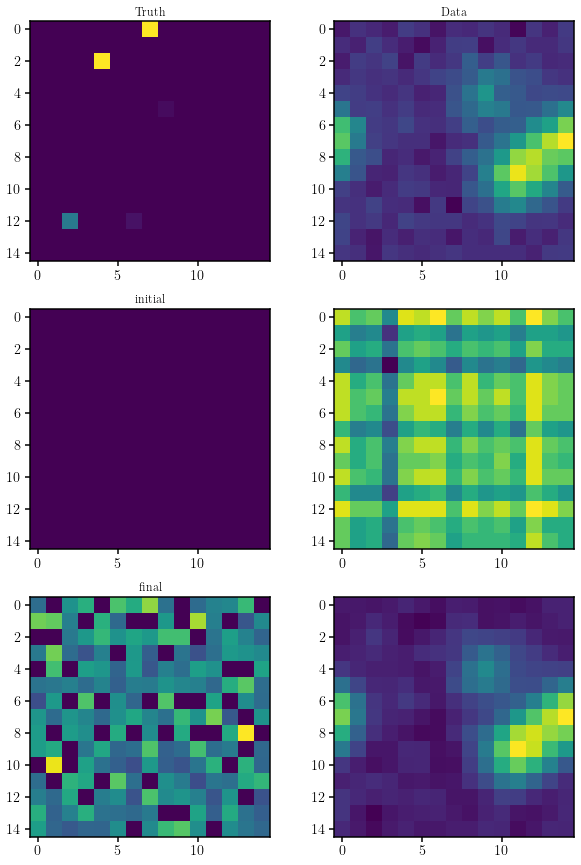

In [25]:
fig, ax = plt.subplots(3,2,figsize=(10,15))
ax[0,0].imshow(w_true_grid)
ax[0,0].set_title('Truth')
ax[0,1].imshow(data)
ax[0,1].set_title('Data')
ax[1,0].imshow(tt0)
ax[1,0].set_title('initial')
ax[1,1].imshow(fm(t_ini))
ax[2,0].imshow(w_final)
ax[2,0].set_title('final')
ax[2,1].imshow(fm(t_f))
plt.show()

In [26]:
print('inital loss: %.5e' % (loss_fn(t_ini, details=True)))
init_fun, update_fun, get_params = adam(1.)

        d - m: [[37.07876  36.900276 36.96075  37.05557  36.813774 36.904335 37.107037
  36.94034  36.960697 36.882587 36.958607 37.204826 36.87449  37.020077
  36.840153]
 [36.933056 37.023552 36.796326 36.936985 37.042877 37.16291  37.010796
  36.810627 36.80256  37.134636 36.934933 36.8529   36.9591   36.95656
  36.852623]
 [37.056816 36.821793 36.869736 36.76986  37.111565 36.826805 36.94972
  36.850502 36.53764  36.79783  36.606865 36.897636 36.8365   36.96506
  36.94359 ]
 [36.95239  36.858925 36.905594 36.882866 36.95961  36.862473 36.766254
  36.698097 36.564587 36.267616 36.372265 36.634163 36.68243  36.852264
  36.897778]
 [36.766235 36.80948  36.894108 36.94499  36.873558 37.016163 36.98215
  36.649914 36.340187 36.013542 36.527603 36.578926 36.722816 36.696583
  36.71829 ]
 [36.321224 36.81798  36.7962   36.903034 36.81354  36.959564 36.932884
  36.61958  36.43801  36.208122 36.285828 36.592106 36.581524 36.37378
  36.13145 ]
 [35.6105   36.15813  36.81824  36.850636 36.736

In [27]:
@jit # ~3x faster with jit
def opt_step_adam(opt_state): 
    tt = get_params(opt_state)
    g = grad(loss_fn)(tt)
    opt_state = update_fun(i, g, opt_state)
    return tt, opt_state

In [28]:
opt_state = init_fun(t_ini)
for i in range(10000):
    tt, opt_state = opt_step_adam(opt_state)
    if np.isnan(loss_fn(tt)): 
        _w_k = real_to_complex(tt)
        _w_k = _w_k.reshape((n_grid,n_grid)) #reshape to 2d
        print('--- w(x) ---')
        print(_w)
        print(loss_fn(tt, details=True))
        break 
        
    print('%i loss:%f' % (i, loss_fn(tt)))
t_f = get_params(opt_state)

print('final loss: %.5e' % (loss_fn(t_f, details=True)))

0 loss:15154971.000000
1 loss:15108540.000000
2 loss:15047326.000000
3 loss:14977027.000000
4 loss:14900218.000000
5 loss:14818454.000000
6 loss:14732986.000000
7 loss:14644874.000000
8 loss:14555241.000000
9 loss:14464818.000000
10 loss:14374118.000000
11 loss:14283368.000000
12 loss:14192769.000000
13 loss:14102553.000000
14 loss:14012903.000000
15 loss:13924058.000000
16 loss:13836190.000000
17 loss:13749386.000000
18 loss:13663672.000000
19 loss:13579072.000000
20 loss:13495628.000000
21 loss:13413381.000000
22 loss:13332324.000000
23 loss:13252505.000000
24 loss:13173905.000000
25 loss:13096531.000000
26 loss:13020334.000000
27 loss:12945302.000000
28 loss:12871444.000000
29 loss:12798783.000000
30 loss:12727301.000000
31 loss:12656926.000000
32 loss:12587638.000000
33 loss:12519411.000000
34 loss:12452224.000000
35 loss:12386057.000000
36 loss:12320883.000000
37 loss:12256688.000000
38 loss:12193422.000000
39 loss:12131080.000000
40 loss:12069652.000000
41 loss:12009090.000000
42

347 loss:4739331.500000
348 loss:4727810.500000
349 loss:4716316.000000
350 loss:4704852.000000
351 loss:4693422.000000
352 loss:4682013.000000
353 loss:4670632.500000
354 loss:4659289.000000
355 loss:4647982.500000
356 loss:4636706.500000
357 loss:4625455.500000
358 loss:4614232.500000
359 loss:4603048.500000
360 loss:4591902.500000
361 loss:4580797.500000
362 loss:4569730.000000
363 loss:4558701.000000
364 loss:4547707.500000
365 loss:4536735.500000
366 loss:4525778.000000
367 loss:4514837.000000
368 loss:4503922.000000
369 loss:4493035.000000
370 loss:4482183.500000
371 loss:4471375.000000
372 loss:4460608.000000
373 loss:4449883.500000
374 loss:4439198.500000
375 loss:4428548.500000
376 loss:4417928.000000
377 loss:4407336.500000
378 loss:4396771.500000
379 loss:4386232.000000
380 loss:4375720.500000
381 loss:4365231.500000
382 loss:4354765.500000
383 loss:4344320.500000
384 loss:4333904.000000
385 loss:4323520.000000
386 loss:4313173.500000
387 loss:4302862.500000
388 loss:4292588

691 loss:2121719.000000
692 loss:2116805.750000
693 loss:2111896.250000
694 loss:2106996.000000
695 loss:2102108.750000
696 loss:2097236.000000
697 loss:2092375.250000
698 loss:2087514.375000
699 loss:2082661.750000
700 loss:2077821.625000
701 loss:2072997.750000
702 loss:2068191.250000
703 loss:2063400.875000
704 loss:2058625.875000
705 loss:2053866.250000
706 loss:2049119.125000
707 loss:2044384.250000
708 loss:2039659.000000
709 loss:2034943.500000
710 loss:2030236.625000
711 loss:2025539.250000
712 loss:2020852.000000
713 loss:2016174.875000
714 loss:2011508.250000
715 loss:2006853.250000
716 loss:2002208.875000
717 loss:1997575.500000
718 loss:1992953.375000
719 loss:1988342.250000
720 loss:1983740.625000
721 loss:1979141.750000
722 loss:1974547.875000
723 loss:1969962.500000
724 loss:1965387.625000
725 loss:1960825.750000
726 loss:1956277.750000
727 loss:1951744.250000
728 loss:1947222.625000
729 loss:1942714.375000
730 loss:1938217.500000
731 loss:1933730.250000
732 loss:1929251

1033 loss:939531.875000
1034 loss:937207.125000
1035 loss:934888.375000
1036 loss:932576.687500
1037 loss:930271.187500
1038 loss:927963.062500
1039 loss:925656.125000
1040 loss:923353.437500
1041 loss:921056.125000
1042 loss:918765.000000
1043 loss:916474.937500
1044 loss:914188.875000
1045 loss:911908.937500
1046 loss:909636.125000
1047 loss:907371.750000
1048 loss:905116.000000
1049 loss:902867.187500
1050 loss:900618.062500
1051 loss:898371.125000
1052 loss:896127.375000
1053 loss:893888.062500
1054 loss:891655.250000
1055 loss:889430.250000
1056 loss:887212.187500
1057 loss:885002.187500
1058 loss:882799.250000
1059 loss:880602.500000
1060 loss:878411.562500
1061 loss:876225.500000
1062 loss:874043.125000
1063 loss:871864.562500
1064 loss:869682.312500
1065 loss:867500.187500
1066 loss:865321.062500
1067 loss:863147.000000
1068 loss:860972.437500
1069 loss:858802.250000
1070 loss:856639.125000
1071 loss:854485.250000
1072 loss:852341.125000
1073 loss:850207.000000
1074 loss:848081

1375 loss:382795.125000
1376 loss:381732.937500
1377 loss:380673.093750
1378 loss:379615.906250
1379 loss:378561.218750
1380 loss:377509.125000
1381 loss:376459.500000
1382 loss:375412.593750
1383 loss:374368.187500
1384 loss:373326.375000
1385 loss:372287.062500
1386 loss:371250.125000
1387 loss:370215.843750
1388 loss:369183.968750
1389 loss:368154.500000
1390 loss:367127.625000
1391 loss:366103.312500
1392 loss:365081.312500
1393 loss:364061.718750
1394 loss:363044.750000
1395 loss:362030.250000
1396 loss:361018.187500
1397 loss:360008.531250
1398 loss:359001.468750
1399 loss:357996.718750
1400 loss:356994.468750
1401 loss:355994.531250
1402 loss:354989.343750
1403 loss:353981.906250
1404 loss:352975.218750
1405 loss:351971.687500
1406 loss:350973.312500
1407 loss:349981.218750
1408 loss:348995.218750
1409 loss:348015.000000
1410 loss:347039.562500
1411 loss:346067.562500
1412 loss:345097.656250
1413 loss:344128.812500
1414 loss:343160.875000
1415 loss:342193.531250
1416 loss:341227

1725 loss:134063.296875
1726 loss:133638.359375
1727 loss:133214.015625
1728 loss:132789.281250
1729 loss:132363.843750
1730 loss:131938.062500
1731 loss:131512.078125
1732 loss:131086.703125
1733 loss:130662.507812
1734 loss:130240.093750
1735 loss:129819.703125
1736 loss:129401.156250
1737 loss:128976.804688
1738 loss:128549.382812
1739 loss:128121.906250
1740 loss:127696.710938
1741 loss:127275.468750
1742 loss:126858.906250
1743 loss:126447.156250
1744 loss:126039.609375
1745 loss:125635.187500
1746 loss:125232.437500
1747 loss:124830.265625
1748 loss:124428.039062
1749 loss:124025.242188
1750 loss:123622.531250
1751 loss:123219.804688
1752 loss:122817.726562
1753 loss:122417.000000
1754 loss:122017.789062
1755 loss:121620.507812
1756 loss:121225.382812
1757 loss:120831.968750
1758 loss:120440.328125
1759 loss:120050.039062
1760 loss:119660.820312
1761 loss:119272.539062
1762 loss:118884.906250
1763 loss:118498.156250
1764 loss:118112.117188
1765 loss:117727.195312
1766 loss:117343

2080 loss:37714.507812
2081 loss:37569.261719
2082 loss:37424.500000
2083 loss:37280.253906
2084 loss:37136.507812
2085 loss:36993.281250
2086 loss:36850.503906
2087 loss:36708.207031
2088 loss:36566.464844
2089 loss:36425.144531
2090 loss:36284.332031
2091 loss:36143.968750
2092 loss:36004.125000
2093 loss:35864.742188
2094 loss:35725.824219
2095 loss:35587.382812
2096 loss:35449.453125
2097 loss:35311.945312
2098 loss:35174.929688
2099 loss:35038.375000
2100 loss:34902.332031
2101 loss:34766.699219
2102 loss:34631.531250
2103 loss:34496.839844
2104 loss:34362.585938
2105 loss:34228.835938
2106 loss:34095.570312
2107 loss:33962.746094
2108 loss:33830.351562
2109 loss:33698.449219
2110 loss:33566.964844
2111 loss:33435.949219
2112 loss:33305.355469
2113 loss:33175.253906
2114 loss:33045.535156
2115 loss:32916.335938
2116 loss:32787.632812
2117 loss:32659.273438
2118 loss:32531.373047
2119 loss:32403.904297
2120 loss:32276.914062
2121 loss:32150.349609
2122 loss:32024.228516
2123 loss:3

2438 loss:8448.166992
2439 loss:8410.262695
2440 loss:8372.575195
2441 loss:8335.005859
2442 loss:8297.565430
2443 loss:8260.322266
2444 loss:8223.225586
2445 loss:8186.272949
2446 loss:8149.478516
2447 loss:8112.854492
2448 loss:8076.358398
2449 loss:8040.022949
2450 loss:8003.821289
2451 loss:7967.805176
2452 loss:7931.882324
2453 loss:7896.158691
2454 loss:7860.581055
2455 loss:7825.134766
2456 loss:7789.844727
2457 loss:7754.690430
2458 loss:7719.697266
2459 loss:7684.840332
2460 loss:7650.128418
2461 loss:7615.576660
2462 loss:7581.161133
2463 loss:7546.897461
2464 loss:7512.749512
2465 loss:7478.771973
2466 loss:7444.928223
2467 loss:7411.212402
2468 loss:7377.661621
2469 loss:7344.255371
2470 loss:7310.966797
2471 loss:7277.818848
2472 loss:7244.805664
2473 loss:7211.967285
2474 loss:7179.239258
2475 loss:7146.643066
2476 loss:7114.216309
2477 loss:7081.912598
2478 loss:7049.715332
2479 loss:7017.666016
2480 loss:6985.765137
2481 loss:6953.993652
2482 loss:6922.364258
2483 loss:

2816 loss:1454.064819
2817 loss:1447.430542
2818 loss:1440.838989
2819 loss:1434.272461
2820 loss:1427.752197
2821 loss:1421.259399
2822 loss:1414.798584
2823 loss:1408.369751
2824 loss:1401.981323
2825 loss:1395.618408
2826 loss:1389.286865
2827 loss:1382.987305
2828 loss:1376.726074
2829 loss:1370.497925
2830 loss:1364.295776
2831 loss:1358.130493
2832 loss:1351.991577
2833 loss:1345.888184
2834 loss:1339.810303
2835 loss:1333.776123
2836 loss:1327.752319
2837 loss:1321.777832
2838 loss:1315.827148
2839 loss:1309.912354
2840 loss:1304.022705
2841 loss:1298.162842
2842 loss:1292.339966
2843 loss:1286.541748
2844 loss:1280.772949
2845 loss:1275.046265
2846 loss:1269.326172
2847 loss:1263.651733
2848 loss:1258.010254
2849 loss:1252.389404
2850 loss:1246.797974
2851 loss:1241.237061
2852 loss:1235.707153
2853 loss:1230.205444
2854 loss:1224.727661
2855 loss:1219.276978
2856 loss:1213.869751
2857 loss:1208.482056
2858 loss:1203.119141
2859 loss:1197.786621
2860 loss:1192.485718
2861 loss:

3204 loss:378.890564
3205 loss:378.172485
3206 loss:377.457458
3207 loss:376.744385
3208 loss:376.037354
3209 loss:375.334412
3210 loss:374.635345
3211 loss:373.942749
3212 loss:373.252289
3213 loss:372.566895
3214 loss:371.887878
3215 loss:371.207886
3216 loss:370.536621
3217 loss:369.870239
3218 loss:369.205627
3219 loss:368.544159
3220 loss:367.890930
3221 loss:367.243256
3222 loss:366.593658
3223 loss:365.949707
3224 loss:365.313232
3225 loss:364.676819
3226 loss:364.045044
3227 loss:363.421021
3228 loss:362.797913
3229 loss:362.180542
3230 loss:361.565674
3231 loss:360.955872
3232 loss:360.347534
3233 loss:359.748047
3234 loss:359.146179
3235 loss:358.553070
3236 loss:357.961334
3237 loss:357.373138
3238 loss:356.789978
3239 loss:356.212646
3240 loss:355.636261
3241 loss:355.064209
3242 loss:354.496704
3243 loss:353.927826
3244 loss:353.367615
3245 loss:352.811829
3246 loss:352.259033
3247 loss:351.707703
3248 loss:351.160156
3249 loss:350.616150
3250 loss:350.079407
3251 loss:349

3606 loss:278.557953
3607 loss:278.517181
3608 loss:278.475281
3609 loss:278.435913
3610 loss:278.396698
3611 loss:278.357361
3612 loss:278.318451
3613 loss:278.280579
3614 loss:278.243164
3615 loss:278.206726
3616 loss:278.169434
3617 loss:278.134308
3618 loss:278.100708
3619 loss:278.067627
3620 loss:278.034546
3621 loss:278.002686
3622 loss:277.969757
3623 loss:277.934052
3624 loss:277.897400
3625 loss:277.856140
3626 loss:277.814606
3627 loss:277.770935
3628 loss:277.729553
3629 loss:277.691711
3630 loss:277.656982
3631 loss:277.625275
3632 loss:277.595581
3633 loss:277.563751
3634 loss:277.531921
3635 loss:277.498657
3636 loss:277.464050
3637 loss:277.429932
3638 loss:277.393433
3639 loss:277.361877
3640 loss:277.329681
3641 loss:277.299866
3642 loss:277.268982
3643 loss:277.241058
3644 loss:277.209900
3645 loss:277.179504
3646 loss:277.147644
3647 loss:277.116943
3648 loss:277.086700
3649 loss:277.057434
3650 loss:277.027832
3651 loss:276.999939
3652 loss:276.971771
3653 loss:276

4002 loss:273.807373
4003 loss:273.807068
4004 loss:273.804779
4005 loss:273.804443
4006 loss:273.802795
4007 loss:273.802521
4008 loss:273.800690
4009 loss:273.799683
4010 loss:273.798157
4011 loss:273.797607
4012 loss:273.795654
4013 loss:273.795410
4014 loss:273.794220
4015 loss:273.792725
4016 loss:273.791931
4017 loss:273.790131
4018 loss:273.789856
4019 loss:273.789185
4020 loss:273.788086
4021 loss:273.786377
4022 loss:273.785400
4023 loss:273.785492
4024 loss:273.783081
4025 loss:273.782837
4026 loss:273.781616
4027 loss:273.780029
4028 loss:273.779907
4029 loss:273.779816
4030 loss:273.778046
4031 loss:273.776794
4032 loss:273.775909
4033 loss:273.775391
4034 loss:273.773773
4035 loss:273.773743
4036 loss:273.773163
4037 loss:273.772003
4038 loss:273.770630
4039 loss:273.769989
4040 loss:273.769897
4041 loss:273.768524
4042 loss:273.767822
4043 loss:273.766724
4044 loss:273.765686
4045 loss:273.765442
4046 loss:273.763916
4047 loss:273.763794
4048 loss:273.762756
4049 loss:273

4403 loss:273.691589
4404 loss:273.692566
4405 loss:273.692383
4406 loss:273.693420
4407 loss:273.693939
4408 loss:273.693176
4409 loss:273.692078
4410 loss:273.691925
4411 loss:273.692322
4412 loss:273.692535
4413 loss:273.692688
4414 loss:273.692993
4415 loss:273.693207
4416 loss:273.692078
4417 loss:273.692688
4418 loss:273.692810
4419 loss:273.691284
4420 loss:273.691956
4421 loss:273.691498
4422 loss:273.691254
4423 loss:273.692657
4424 loss:273.691559
4425 loss:273.692200
4426 loss:273.692352
4427 loss:273.692230
4428 loss:273.691681
4429 loss:273.691895
4430 loss:273.692749
4431 loss:273.691803
4432 loss:273.692383
4433 loss:273.692383
4434 loss:273.693359
4435 loss:273.693634
4436 loss:273.695526
4437 loss:273.695740
4438 loss:273.699585
4439 loss:273.702881
4440 loss:273.707642
4441 loss:273.713867
4442 loss:273.718933
4443 loss:273.725128
4444 loss:273.726318
4445 loss:273.725159
4446 loss:273.721130
4447 loss:273.717346
4448 loss:273.713928
4449 loss:273.710938
4450 loss:273

4797 loss:273.714233
4798 loss:273.708252
4799 loss:273.703339
4800 loss:273.703186
4801 loss:273.708679
4802 loss:273.715851
4803 loss:273.721222
4804 loss:273.720337
4805 loss:273.716156
4806 loss:273.708710
4807 loss:273.702576
4808 loss:273.699860
4809 loss:273.700439
4810 loss:273.702911
4811 loss:273.702850
4812 loss:273.700226
4813 loss:273.697327
4814 loss:273.694763
4815 loss:273.692688
4816 loss:273.693604
4817 loss:273.695587
4818 loss:273.696472
4819 loss:273.696014
4820 loss:273.695404
4821 loss:273.694885
4822 loss:273.693817
4823 loss:273.692749
4824 loss:273.692352
4825 loss:273.691986
4826 loss:273.691589
4827 loss:273.692444
4828 loss:273.692932
4829 loss:273.692841
4830 loss:273.692566
4831 loss:273.692261
4832 loss:273.692017
4833 loss:273.692169
4834 loss:273.691376
4835 loss:273.691071
4836 loss:273.691803
4837 loss:273.691528
4838 loss:273.691528
4839 loss:273.691010
4840 loss:273.691010
4841 loss:273.690796
4842 loss:273.690369
4843 loss:273.691467
4844 loss:273

5189 loss:273.695892
5190 loss:273.696167
5191 loss:273.698090
5192 loss:273.700836
5193 loss:273.703186
5194 loss:273.707214
5195 loss:273.710449
5196 loss:273.710693
5197 loss:273.708618
5198 loss:273.705078
5199 loss:273.699280
5200 loss:273.694183
5201 loss:273.692596
5202 loss:273.692078
5203 loss:273.695068
5204 loss:273.696869
5205 loss:273.699036
5206 loss:273.698334
5207 loss:273.697754
5208 loss:273.695526
5209 loss:273.695435
5210 loss:273.696106
5211 loss:273.698181
5212 loss:273.700684
5213 loss:273.703217
5214 loss:273.704529
5215 loss:273.704163
5216 loss:273.702911
5217 loss:273.701050
5218 loss:273.699585
5219 loss:273.696777
5220 loss:273.695740
5221 loss:273.693115
5222 loss:273.692841
5223 loss:273.693237
5224 loss:273.694733
5225 loss:273.695496
5226 loss:273.697510
5227 loss:273.699341
5228 loss:273.700043
5229 loss:273.701141
5230 loss:273.703003
5231 loss:273.705017
5232 loss:273.706726
5233 loss:273.709686
5234 loss:273.713531
5235 loss:273.716553
5236 loss:273

5582 loss:273.711670
5583 loss:273.713745
5584 loss:273.716400
5585 loss:273.716827
5586 loss:273.714783
5587 loss:273.710205
5588 loss:273.705811
5589 loss:273.703186
5590 loss:273.700623
5591 loss:273.701233
5592 loss:273.701416
5593 loss:273.702759
5594 loss:273.700348
5595 loss:273.698761
5596 loss:273.695312
5597 loss:273.693268
5598 loss:273.692230
5599 loss:273.694153
5600 loss:273.695984
5601 loss:273.697449
5602 loss:273.696808
5603 loss:273.696320
5604 loss:273.693481
5605 loss:273.692078
5606 loss:273.691528
5607 loss:273.690918
5608 loss:273.691803
5609 loss:273.693481
5610 loss:273.693604
5611 loss:273.693176
5612 loss:273.692261
5613 loss:273.691864
5614 loss:273.690948
5615 loss:273.691162
5616 loss:273.690918
5617 loss:273.691162
5618 loss:273.691772
5619 loss:273.691895
5620 loss:273.691345
5621 loss:273.690857
5622 loss:273.690643
5623 loss:273.690796
5624 loss:273.691376
5625 loss:273.690948
5626 loss:273.691772
5627 loss:273.691864
5628 loss:273.691193
5629 loss:273

5978 loss:273.722778
5979 loss:273.729553
5980 loss:273.737305
5981 loss:273.740967
5982 loss:273.741028
5983 loss:273.738159
5984 loss:273.735260
5985 loss:273.733948
5986 loss:273.733459
5987 loss:273.731812
5988 loss:273.728638
5989 loss:273.722168
5990 loss:273.717102
5991 loss:273.711243
5992 loss:273.707153
5993 loss:273.703918
5994 loss:273.703369
5995 loss:273.704498
5996 loss:273.706848
5997 loss:273.709595
5998 loss:273.710205
5999 loss:273.710358
6000 loss:273.707947
6001 loss:273.704773
6002 loss:273.701630
6003 loss:273.699768
6004 loss:273.698883
6005 loss:273.697998
6006 loss:273.697327
6007 loss:273.694672
6008 loss:273.693695
6009 loss:273.693939
6010 loss:273.695007
6011 loss:273.696838
6012 loss:273.696228
6013 loss:273.695923
6014 loss:273.694305
6015 loss:273.692291
6016 loss:273.691986
6017 loss:273.691681
6018 loss:273.691650
6019 loss:273.692841
6020 loss:273.693085
6021 loss:273.692474
6022 loss:273.693024
6023 loss:273.691650
6024 loss:273.692108
6025 loss:273

6373 loss:273.796936
6374 loss:273.794098
6375 loss:273.775940
6376 loss:273.746857
6377 loss:273.722229
6378 loss:273.711853
6379 loss:273.717712
6380 loss:273.730988
6381 loss:273.742065
6382 loss:273.742920
6383 loss:273.734589
6384 loss:273.724976
6385 loss:273.719757
6386 loss:273.721436
6387 loss:273.726624
6388 loss:273.731384
6389 loss:273.734283
6390 loss:273.737793
6391 loss:273.747314
6392 loss:273.760315
6393 loss:273.774780
6394 loss:273.784912
6395 loss:273.788391
6396 loss:273.786285
6397 loss:273.780640
6398 loss:273.773254
6399 loss:273.766571
6400 loss:273.757843
6401 loss:273.749329
6402 loss:273.743744
6403 loss:273.743317
6404 loss:273.749451
6405 loss:273.758514
6406 loss:273.764893
6407 loss:273.766296
6408 loss:273.760803
6409 loss:273.752380
6410 loss:273.746460
6411 loss:273.746857
6412 loss:273.749725
6413 loss:273.749268
6414 loss:273.743195
6415 loss:273.729736
6416 loss:273.715759
6417 loss:273.709259
6418 loss:273.709137
6419 loss:273.714813
6420 loss:273

6770 loss:273.710632
6771 loss:273.708862
6772 loss:273.710785
6773 loss:273.714569
6774 loss:273.715271
6775 loss:273.712372
6776 loss:273.706238
6777 loss:273.700043
6778 loss:273.696167
6779 loss:273.696075
6780 loss:273.698486
6781 loss:273.702606
6782 loss:273.703796
6783 loss:273.703857
6784 loss:273.702942
6785 loss:273.701965
6786 loss:273.703125
6787 loss:273.707153
6788 loss:273.711334
6789 loss:273.718231
6790 loss:273.724274
6791 loss:273.730377
6792 loss:273.733582
6793 loss:273.735260
6794 loss:273.731476
6795 loss:273.724701
6796 loss:273.714539
6797 loss:273.703918
6798 loss:273.697876
6799 loss:273.696625
6800 loss:273.700256
6801 loss:273.707336
6802 loss:273.714447
6803 loss:273.722321
6804 loss:273.726776
6805 loss:273.732697
6806 loss:273.737244
6807 loss:273.737976
6808 loss:273.731293
6809 loss:273.718506
6810 loss:273.708771
6811 loss:273.710327
6812 loss:273.720093
6813 loss:273.727814
6814 loss:273.726837
6815 loss:273.720703
6816 loss:273.718933
6817 loss:273

7175 loss:273.711914
7176 loss:273.708679
7177 loss:273.706482
7178 loss:273.706482
7179 loss:273.707520
7180 loss:273.710327
7181 loss:273.714447
7182 loss:273.716675
7183 loss:273.721191
7184 loss:273.726044
7185 loss:273.733643
7186 loss:273.742340
7187 loss:273.749329
7188 loss:273.752167
7189 loss:273.745789
7190 loss:273.730804
7191 loss:273.711853
7192 loss:273.701477
7193 loss:273.702454
7194 loss:273.711700
7195 loss:273.723145
7196 loss:273.728241
7197 loss:273.725006
7198 loss:273.718628
7199 loss:273.716736
7200 loss:273.721191
7201 loss:273.728394
7202 loss:273.732635
7203 loss:273.728333
7204 loss:273.718536
7205 loss:273.709412
7206 loss:273.707184
7207 loss:273.714355
7208 loss:273.727142
7209 loss:273.742310
7210 loss:273.758545
7211 loss:273.775513
7212 loss:273.795166
7213 loss:273.815216
7214 loss:273.829742
7215 loss:273.832092
7216 loss:273.824036
7217 loss:273.812012
7218 loss:273.798035
7219 loss:273.778748
7220 loss:273.754669
7221 loss:273.733765
7222 loss:273

7567 loss:273.757233
7568 loss:273.768494
7569 loss:273.782898
7570 loss:273.793884
7571 loss:273.793976
7572 loss:273.782074
7573 loss:273.762360
7574 loss:273.740234
7575 loss:273.723846
7576 loss:273.719116
7577 loss:273.722321
7578 loss:273.731628
7579 loss:273.740356
7580 loss:273.745911
7581 loss:273.750275
7582 loss:273.753418
7583 loss:273.758179
7584 loss:273.760132
7585 loss:273.759949
7586 loss:273.754425
7587 loss:273.740204
7588 loss:273.725250
7589 loss:273.712219
7590 loss:273.708466
7591 loss:273.711487
7592 loss:273.718964
7593 loss:273.726807
7594 loss:273.732361
7595 loss:273.732971
7596 loss:273.732605
7597 loss:273.732056
7598 loss:273.734528
7599 loss:273.737671
7600 loss:273.740570
7601 loss:273.740051
7602 loss:273.734070
7603 loss:273.725891
7604 loss:273.720093
7605 loss:273.717438
7606 loss:273.719849
7607 loss:273.725830
7608 loss:273.734344
7609 loss:273.741974
7610 loss:273.750488
7611 loss:273.757965
7612 loss:273.763458
7613 loss:273.767578
7614 loss:273

7965 loss:273.734344
7966 loss:273.728821
7967 loss:273.722717
7968 loss:273.721191
7969 loss:273.721405
7970 loss:273.722717
7971 loss:273.720703
7972 loss:273.716461
7973 loss:273.714447
7974 loss:273.713593
7975 loss:273.712250
7976 loss:273.711578
7977 loss:273.708954
7978 loss:273.705170
7979 loss:273.702240
7980 loss:273.700653
7981 loss:273.700623
7982 loss:273.702698
7983 loss:273.703918
7984 loss:273.703491
7985 loss:273.703705
7986 loss:273.702942
7987 loss:273.705322
7988 loss:273.707855
7989 loss:273.710938
7990 loss:273.713867
7991 loss:273.713623
7992 loss:273.710815
7993 loss:273.707062
7994 loss:273.703217
7995 loss:273.700317
7996 loss:273.700134
7997 loss:273.700317
7998 loss:273.701874
7999 loss:273.703064
8000 loss:273.704285
8001 loss:273.706055
8002 loss:273.709839
8003 loss:273.714569
8004 loss:273.725128
8005 loss:273.738678
8006 loss:273.752197
8007 loss:273.761169
8008 loss:273.760284
8009 loss:273.747742
8010 loss:273.728241
8011 loss:273.714111
8012 loss:273

8359 loss:273.702057
8360 loss:273.704590
8361 loss:273.707031
8362 loss:273.708221
8363 loss:273.707642
8364 loss:273.708862
8365 loss:273.709717
8366 loss:273.709534
8367 loss:273.709717
8368 loss:273.709808
8369 loss:273.707092
8370 loss:273.704651
8371 loss:273.701843
8372 loss:273.700043
8373 loss:273.700134
8374 loss:273.702087
8375 loss:273.704681
8376 loss:273.707336
8377 loss:273.707855
8378 loss:273.706970
8379 loss:273.703033
8380 loss:273.698303
8381 loss:273.696350
8382 loss:273.696838
8383 loss:273.698700
8384 loss:273.703003
8385 loss:273.706177
8386 loss:273.709961
8387 loss:273.714417
8388 loss:273.719086
8389 loss:273.725342
8390 loss:273.733307
8391 loss:273.741852
8392 loss:273.748230
8393 loss:273.749817
8394 loss:273.743286
8395 loss:273.730621
8396 loss:273.715179
8397 loss:273.702728
8398 loss:273.699158
8399 loss:273.701233
8400 loss:273.706818
8401 loss:273.712311
8402 loss:273.713135
8403 loss:273.710052
8404 loss:273.707672
8405 loss:273.706573
8406 loss:273

8758 loss:273.714447
8759 loss:273.704651
8760 loss:273.701141
8761 loss:273.701508
8762 loss:273.705536
8763 loss:273.710480
8764 loss:273.712189
8765 loss:273.710724
8766 loss:273.707977
8767 loss:273.704437
8768 loss:273.701050
8769 loss:273.701050
8770 loss:273.703857
8771 loss:273.708008
8772 loss:273.712280
8773 loss:273.716644
8774 loss:273.719849
8775 loss:273.723145
8776 loss:273.725067
8777 loss:273.726196
8778 loss:273.727051
8779 loss:273.726440
8780 loss:273.725037
8781 loss:273.720886
8782 loss:273.714783
8783 loss:273.707733
8784 loss:273.703491
8785 loss:273.703369
8786 loss:273.704712
8787 loss:273.708923
8788 loss:273.711792
8789 loss:273.713379
8790 loss:273.711792
8791 loss:273.709442
8792 loss:273.708069
8793 loss:273.707977
8794 loss:273.708771
8795 loss:273.711273
8796 loss:273.712311
8797 loss:273.716705
8798 loss:273.721436
8799 loss:273.726685
8800 loss:273.734955
8801 loss:273.741882
8802 loss:273.747009
8803 loss:273.748840
8804 loss:273.745087
8805 loss:273

9159 loss:273.738251
9160 loss:273.756409
9161 loss:273.779907
9162 loss:273.795135
9163 loss:273.793976
9164 loss:273.770386
9165 loss:273.734222
9166 loss:273.705963
9167 loss:273.699646
9168 loss:273.711884
9169 loss:273.730591
9170 loss:273.739685
9171 loss:273.737183
9172 loss:273.724823
9173 loss:273.718140
9174 loss:273.723022
9175 loss:273.738251
9176 loss:273.753601
9177 loss:273.761230
9178 loss:273.758423
9179 loss:273.745514
9180 loss:273.732513
9181 loss:273.718506
9182 loss:273.710083
9183 loss:273.706024
9184 loss:273.707733
9185 loss:273.711853
9186 loss:273.717194
9187 loss:273.721405
9188 loss:273.719421
9189 loss:273.716187
9190 loss:273.711975
9191 loss:273.712097
9192 loss:273.717010
9193 loss:273.723358
9194 loss:273.729919
9195 loss:273.729675
9196 loss:273.725647
9197 loss:273.720398
9198 loss:273.714294
9199 loss:273.709106
9200 loss:273.706299
9201 loss:273.704468
9202 loss:273.702576
9203 loss:273.701843
9204 loss:273.700012
9205 loss:273.701416
9206 loss:273

9552 loss:273.707977
9553 loss:273.713196
9554 loss:273.715942
9555 loss:273.715973
9556 loss:273.718567
9557 loss:273.724152
9558 loss:273.735687
9559 loss:273.752350
9560 loss:273.765717
9561 loss:273.770935
9562 loss:273.762543
9563 loss:273.743530
9564 loss:273.723816
9565 loss:273.710876
9566 loss:273.708710
9567 loss:273.714020
9568 loss:273.717651
9569 loss:273.717377
9570 loss:273.712311
9571 loss:273.706787
9572 loss:273.704376
9573 loss:273.707001
9574 loss:273.710602
9575 loss:273.712311
9576 loss:273.710693
9577 loss:273.707672
9578 loss:273.707916
9579 loss:273.712524
9580 loss:273.718994
9581 loss:273.727509
9582 loss:273.731995
9583 loss:273.733948
9584 loss:273.734436
9585 loss:273.733490
9586 loss:273.729279
9587 loss:273.722595
9588 loss:273.717163
9589 loss:273.713959
9590 loss:273.718018
9591 loss:273.729584
9592 loss:273.742157
9593 loss:273.756134
9594 loss:273.766388
9595 loss:273.772797
9596 loss:273.774536
9597 loss:273.770386
9598 loss:273.760895
9599 loss:273

9944 loss:273.746826
9945 loss:273.757568
9946 loss:273.761261
9947 loss:273.752930
9948 loss:273.736908
9949 loss:273.719543
9950 loss:273.711975
9951 loss:273.714111
9952 loss:273.723877
9953 loss:273.732849
9954 loss:273.736664
9955 loss:273.735199
9956 loss:273.734070
9957 loss:273.739441
9958 loss:273.752991
9959 loss:273.770477
9960 loss:273.783478
9961 loss:273.784149
9962 loss:273.771210
9963 loss:273.747162
9964 loss:273.726471
9965 loss:273.718933
9966 loss:273.725006
9967 loss:273.739441
9968 loss:273.751343
9969 loss:273.756561
9970 loss:273.756042
9971 loss:273.751709
9972 loss:273.747528
9973 loss:273.749237
9974 loss:273.760193
9975 loss:273.779999
9976 loss:273.803497
9977 loss:273.817627
9978 loss:273.817383
9979 loss:273.800476
9980 loss:273.773926
9981 loss:273.752747
9982 loss:273.745728
9983 loss:273.750092
9984 loss:273.753571
9985 loss:273.750000
9986 loss:273.742340
9987 loss:273.735687
9988 loss:273.736633
9989 loss:273.742096
9990 loss:273.746246
9991 loss:273

In [29]:
w_final_k = real_to_complex(t_f)
w_final_k = w_final_k.reshape((n_grid,n_grid)) #reshape to 2d
w_final = np.real(np.fft.ifft2(w_final_k))

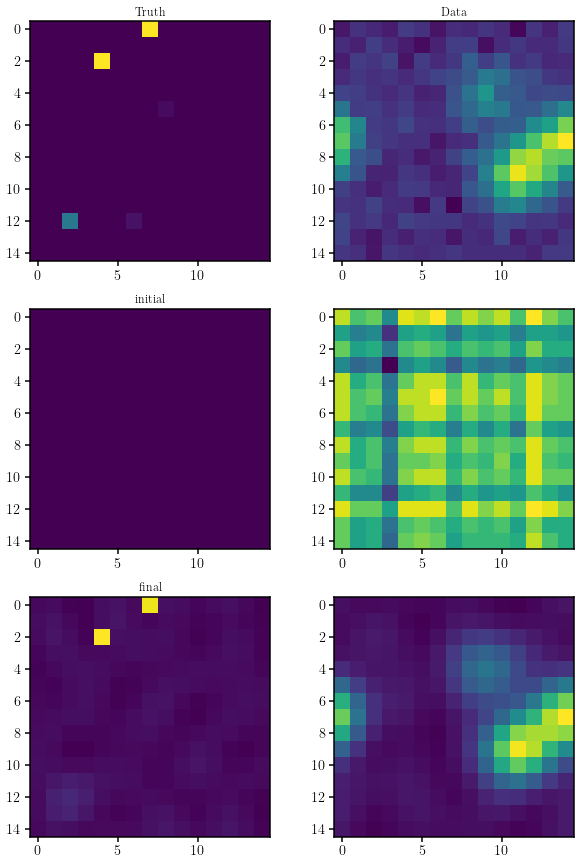

In [30]:
fig, ax = plt.subplots(3,2,figsize=(10,15))
ax[0,0].imshow(w_true_grid)
ax[0,0].set_title('Truth')
ax[0,1].imshow(data)
ax[0,1].set_title('Data')
ax[1,0].imshow(tt0)
ax[1,0].set_title('initial')
ax[1,1].imshow(fm(t_ini))
ax[2,0].imshow(w_final)
ax[2,0].set_title('final')
ax[2,1].imshow(fm(t_f))
plt.show()